# 获取下载rs的城市边界

In [14]:
import pandas as pd
import geopandas as gpd



## 方案一 直接根据panoid的外包多边形。边界不够精确

In [ ]:
import geopandas as gpd
# 读取shp文件
gdf = gpd.read_file('/data_nas/huangyj/GoogleSV/metadata/US/LosAngeles/city_2.shp')

# 将所有几何对象合并成一个整体
merged_geom = gdf.unary_union

# 生成外包多边形
convex_hull = merged_geom.convex_hull

# 将外包多边形保存为一个新的 GeoDataFrame
convex_hull_gdf = gpd.GeoDataFrame(geometry=[convex_hull], crs=gdf.crs)

# 可视化外包多边形
convex_hull_gdf.plot()

# # 保存为新的shp文件
convex_hull_gdf.to_file('/data_nas/huangyj/GoogleSV/metadata/US/LosAngeles/city_2_convex_hull.shp')


In [12]:
# 计算外包多边形（Convex Hull）
hull = gdf.unary_union.convex_hull.buffer(-0.005)
# 创建 GeoDataFrame 存储外包多边形
gdf_hull = gpd.GeoDataFrame(geometry=[hull], crs=gdf.crs)

# 可视化外包多边形
gdf_hull.plot(color='blue', alpha=0.5, edgecolor='black')



<Axes: >

## 方案二 每个point 生成缓冲区，在计算边界

In [ ]:
import pandas as pd
import alphashape
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd

# 假设您的 panoids_all.p 数据包含经纬度信息
# 加载数据
panoids_all = pd.read_csv('/data_nas/huangyj/GoogleSV/metadata/US/LosAngeles/panoids_all.csv')

# 删除包含 NaN 值的行
panoids_all = panoids_all.dropna(subset=['lat'])

# 打印清理后的 DataFrame 的前几行
print("清理后的 DataFrame:")
print(panoids_all.head())

# 计算清理后的总行数
print(f"清理后的总行数: {panoids_all.shape[0]}")

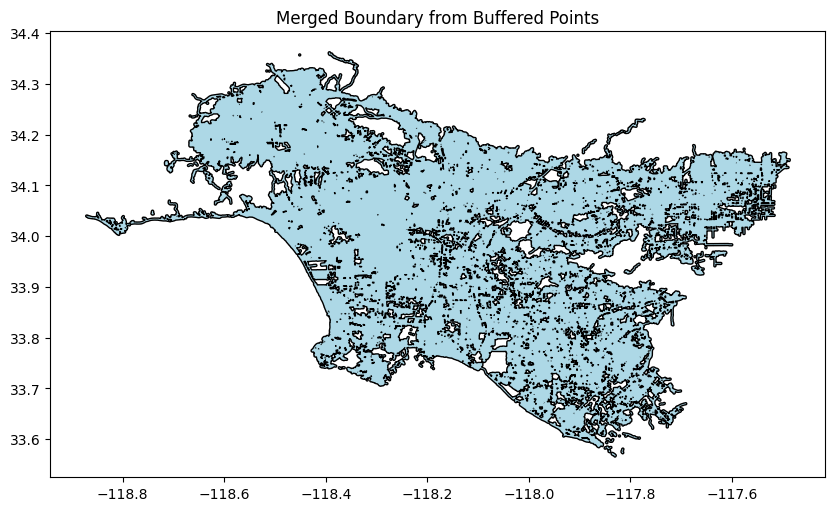

In [16]:


# 删除NaN值
panoids_all = panoids_all.dropna(subset=['lat', 'lon'])

# 创建GeoDataFrame并将点转换为Shapely的Point对象
gdf_points = gpd.GeoDataFrame(panoids_all, geometry=gpd.points_from_xy(panoids_all['lon'], panoids_all['lat']))

# 设置缓冲区半径，单位是与坐标系一致的单位（如果是经纬度，单位是度，较小值如0.01度）
buffer_radius = 0.0020  # 根据需要调整缓冲区的大小

# 为每个点生成缓冲区
gdf_points['buffer'] = gdf_points['geometry'].buffer(buffer_radius)

# 合并所有缓冲区
merged_boundary = gdf_points['buffer'].unary_union

# 将合并后的边界转换为GeoDataFrame
gdf_boundary = gpd.GeoDataFrame(geometry=[merged_boundary])

# 可视化合并后的边界
fig, ax = plt.subplots(figsize=(10, 10))
gdf_boundary.plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title('Merged Boundary from Buffered Points')
plt.show()

# 保存到Shapefile
gdf_boundary.to_file('merged_boundary.shp')


/tmp/ipykernel_16318/669455847.py:23: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_cleaned['geometry'] = gdf['geometry'].buffer(0).apply(remove_interior_rings)


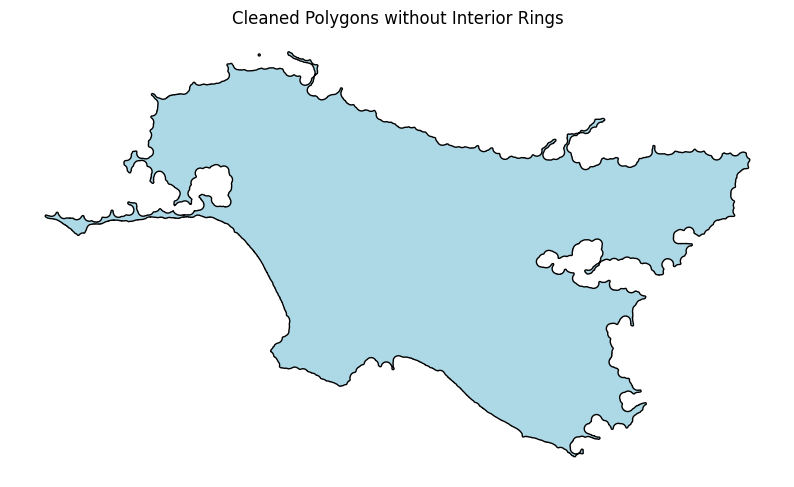

导出完成


In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

# 读取原始 GeoDataFrame（替换为你的数据文件路径）
gdf = new_gdf

# 定义去除内环的函数
def remove_interior_rings(geometry):
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            # 仅保留外环
            return Polygon(geometry.exterior)
        else:
            # 保留每个多边形的外环
            return MultiPolygon([Polygon(poly.exterior) for poly in geometry.geoms])
    return geometry

# 创建一个新的 GeoDataFrame
gdf_cleaned = gpd.GeoDataFrame()

# 对几何体进行平滑处理和去内环，并存储在新的 GeoDataFrame 中
gdf_cleaned['geometry'] = gdf['geometry'].buffer(0).apply(remove_interior_rings)

# 可视化新 GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf_cleaned.plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title('Cleaned Polygons without Interior Rings')
ax.set_axis_off()
plt.show()

# 导出到 Shapefile 或 GeoJSON 格式
gdf_cleaned.to_file("la_polygon.shp")  # 或使用 gdf_cleaned.to_file("cleaned_la_polygon.geojson", driver='GeoJSON')

print("导出完成")


# 根据瓦片存储geotif

## 方案一，水经注直接导出裁剪后的，然后根据 导出时间.shp 重命名切片的文件

In [22]:
import os

shp_file = r'/home/liyong/code/GoogleEarth'

print(os.path.exists(shp_file))

False


In [ ]:
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import shutil


# 定义文件路径
request_time = 'T202303'
tif_folder = r'/data_nas/liyong/GoogleEarth/LosAngeles/test/test_大图(3)/L19'
shp_file = r'/data_nas/liyong/GoogleEarth/LosAngeles/test/test_拍摄时间.shp'
tif_folder_new = f'/data_nas/liyong/GoogleEarth/images/LosAngeles/{request_time}'
metadata_folder = r'/data_nas/liyong/GoogleEarth/metadata/LosAngeles'
print(os.path.exists(shp_file))
# 读取shapefile
points_gdf = gpd.read_file(shp_file)

# 遍历所有的tif文件
for tif_file in os.listdir(tif_folder):
    if tif_file.endswith('.tif'):
        tif_path = os.path.join(tif_folder, tif_file)

        # 打开tif文件
        with rasterio.open(tif_path) as src:
            # 获取tif的边界框
            tif_bounds = src.bounds
            tif_box = box(tif_bounds.left, tif_bounds.bottom, tif_bounds.right, tif_bounds.top)

            # 检查哪些点在当前tif文件的范围内
            points_in_tif = points_gdf[points_gdf.geometry.within(tif_box)]

            # 如果有点在这个tif内
            if not points_in_tif.empty:
                for _, point in points_in_tif.iterrows():
                    remark = point['REMARK']  # 获取remark列内容
                    parts = remark.split('_')  # 按照'_'分割remark列
                    time = point['NAME']
                    if len(parts) == 3:
                        # 创建文件夹
                        folder_name = os.path.join(tif_folder_new, parts[0])
                        os.makedirs(folder_name, exist_ok=True)

                        # 新的tif文件名
                        new_tif_name = f"{parts[1]}_{parts[2]}.tif"
                        new_tif_path = os.path.join(folder_name, new_tif_name)

                        # 移动并重命名tif文件
                        # os.rename(tif_path, new_tif_path)
                        # print(f"Moved and renamed {tif_file} to {new_tif_path}")
                        
                        # 复制并重命名tif文件
                        shutil.copy(tif_path, new_tif_path)
                        print(f"Copied and renamed {tif_file} to {new_tif_path}")


In [39]:
import os
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import shutil
from geopandas import GeoDataFrame
from shapely.geometry import Polygon
import pandas as pd

# 定义文件路径
request_time = 'T202402'

tif_folder = r'/data_nas/liyong/GoogleEarth/raw/LosAngeles/rs/rs_大图(2)/L16' # 原始下载的图像
shp_file = r'/data_nas/liyong/GoogleEarth/raw/LosAngeles/rs/rs_大图(2)/rs_拍摄时间.shp' # 导出的拍摄时间
tif_folder_new = f'/data_nas/liyong/GoogleEarth/images/US/LosAngeles/{request_time}' # 新的image路径
metadata_folder = r'/data_nas/liyong/GoogleEarth/metadata/US/LosAngeles' # 新的metadata路径
from tqdm import tqdm  # 导入tqdm
# 检查shapefile是否存在
print(os.path.exists(shp_file))

# 读取shapefile
points_gdf = gpd.read_file(shp_file)

# 创建一个空的 GeoDataFrame 用于存储tif边界信息，并设置 CRS
metadata_gdf = GeoDataFrame(columns=points_gdf.columns.tolist() + ['path'], geometry='geometry', crs=points_gdf.crs)

# 获取tif文件列表
tif_files = [f for f in os.listdir(tif_folder) if f.endswith('.tif')]

# 遍历所有的tif文件，使用tqdm显示进度条
level = ''
for tif_file in tqdm(tif_files, desc="Processing TIFF files"):
    if tif_file.endswith('.tif'):
        tif_path = os.path.join(tif_folder, tif_file)

        # 打开tif文件
        with rasterio.open(tif_path) as src:
            # 获取tif的边界框
            tif_bounds = src.bounds
            tif_box = box(tif_bounds.left, tif_bounds.bottom, tif_bounds.right, tif_bounds.top)

            # 检查哪些点在当前tif文件的范围内
            points_in_tif = points_gdf[points_gdf.geometry.within(tif_box)]

            # 如果有点在这个tif内
            if not points_in_tif.empty:
                for _, point in points_in_tif.iterrows():
                    remark = point['REMARK']  # 获取remark列内容
                    parts = remark.split('_')  # 按照'_'分割remark列
                    time = point['NAME']
                    if len(parts) == 3:
                        level = parts[0]
                        # 创建文件夹
                        folder_name = os.path.join(tif_folder_new, level)
                        os.makedirs(folder_name, exist_ok=True)

                        # 新的tif文件名
                        new_tif_name = f"{parts[1]}_{parts[2]}.tif"
                        new_tif_path = os.path.join(folder_name, new_tif_name)

                        # 复制并重命名tif文件
                        shutil.copy(tif_path, new_tif_path)
                        # print(f"Copied and renamed {tif_file} to {new_tif_path}")

                        # 创建tif文件的多边形（基于边界框）
                        polygon = Polygon([(tif_bounds.left, tif_bounds.bottom), 
                                           (tif_bounds.left, tif_bounds.top), 
                                           (tif_bounds.right, tif_bounds.top), 
                                           (tif_bounds.right, tif_bounds.bottom)])

                        # 为该 tif 文件生成一行新的metadata
                        metadata_row = point.copy()  # 复制点的属性列
                        metadata_row['geometry'] = polygon  # 使用 tif 边界作为geometry
                        metadata_row['path'] = new_tif_path  # 添加path列，记录tif文件路径

                        # 创建 GeoDataFrame 包含单行数据，并设置 CRS
                        metadata_row_gdf = GeoDataFrame([metadata_row], columns=metadata_gdf.columns, crs=points_gdf.crs)

                        # 使用 pd.concat 追加数据
                        metadata_gdf = pd.concat([metadata_gdf, metadata_row_gdf], ignore_index=True)

# 保存metadata GeoDataFrame 为 shapefile
os.makedirs(metadata_folder, exist_ok=True)
metadata_shp_path = os.path.join(metadata_folder, f'{level}_{request_time}.shp')
metadata_gdf.to_file(metadata_shp_path)
print(f"Metadata saved as shapefile: {metadata_shp_path}")


True


Processing TIFF files: 100%|██████████| 5947/5947 [03:32<00:00, 27.93it/s]


Metadata saved as shapefile: /data_nas/liyong/GoogleEarth/metadata/US/LosAngeles/15_T202402.shp


## 方案二， 根据导出的大图， 和导出时间.shp 裁剪重命名文件，

### 小批量测试, 有些边界不够256x256的删除

In [ ]:
import rasterio
from rasterio.windows import Window
import geopandas as gpd
from geopandas import GeoDataFrame
import os
from tqdm import tqdm  # 导入 tqdm 用于进度条

# Load the shapefile
shapefile_path = '/data_nas/liyong/GoogleEarth/raw/LosAngeles/test/test_拍摄时间.shp'
gdf = gpd.read_file(shapefile_path)

# Load the raster file
raster_path = '/data_nas/liyong/GoogleEarth/raw/LosAngeles/test/test_大图/L19/test.tif'

# Define output directory for the cropped images
output_dir = '/data_nas/liyong/GoogleEarth/raw/LosAngeles/test_256_1/'
os.makedirs(output_dir, exist_ok=True)

# 创建一个空的 GeoDataFrame 用于存储tif边界信息，并设置 CRS
metadata_gdf = GeoDataFrame(columns=gdf.columns.tolist() + ['path'], crs=gdf.crs)
# 保存 metadata_gdf 为 shapefile
metadata_output_path = '/data_nas/liyong/GoogleEarth/raw/LosAngeles/test_256_1/metadata.shp'


with rasterio.open(raster_path) as src:

    width = src.width
    height = src.height
    # Loop through each point in the shapefile with tqdm progress bar
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Cropping images"):

        name = row['REMARK']  # Extract the name attribute for naming
        point = row['geometry']  # Get the point geometry (lat, lon)
        parts = name.split('_')  # 按照'_'分割remark列
        level = parts[0]

        # Convert the geographic coordinates (lon, lat) to pixel coordinates
        py, px = src.index(point.x, point.y)
        # 计算窗口左上角坐标
        col_off = px - 128
        row_off = py - 128     
        # 检查窗口是否在图像范围内
        if (col_off >= 0 and row_off >= 0 and 
            col_off + 256 <= width and row_off + 256 <= height):
            
            # Define the window for a 256x256 patch centered on the point
            window = Window(px - 128, py - 128, 256, 256)

            # Read the window from the raster
            patch = src.read(window=window)
            
            # Define the output file name
            folder_name = os.path.join(output_dir, level,parts[1])
            os.makedirs(folder_name, exist_ok=True)
            output_file = os.path.join(folder_name, f"{parts[2]}.tif")
            print(output_file)

            # Write the patch to a new file
            with rasterio.open(
                output_file,
                'w',
                driver='GTiff',
                height=patch.shape[1],
                width=patch.shape[2],
                count=src.count,
                dtype=patch.dtype,
                crs=src.crs,
                transform=src.window_transform(window),
            ) as dst:
                dst.write(patch)

            # 添加路径和几何信息到 metadata_gdf
            new_row = pd.DataFrame([{
                'geometry': row['geometry'],
                'REMARK': row['REMARK'],
                'path': output_file
            }])
            metadata_gdf = pd.concat([metadata_gdf, new_row], ignore_index=True)
        else:
            continue


metadata_gdf.to_file(metadata_output_path)

print("Cropping completed, metadata saved.")


### 多线程处理 

In [15]:
import rasterio
from rasterio.windows import Window
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
import os
from tqdm import tqdm
from multiprocessing import Pool

# Load the shapefile
shapefile_path = '/data_nas/liyong/GoogleEarth/raw/LosAngeles/latest/latest_拍摄时间.shp'
gdf = gpd.read_file(shapefile_path)

# 创建一个空的 GeoDataFrame 用于存储tif边界信息，并设置 CRS
metadata_gdf = GeoDataFrame(columns=gdf.columns.tolist() + ['path'], crs=gdf.crs)
metadata_output_path = '/data_nas/liyong/GoogleEarth/metadata/US/LosAngeles/T_latest_point.shp'
os.makedirs('/data_nas/liyong/GoogleEarth/metadata/US/LosAngeles/', exist_ok=True)

# Load the raster file
raster_path = '/data_nas/liyong/GoogleEarth/raw/LosAngeles/latest/latest_大图/L19/latest.tif'

# Define output directory for the cropped images
output_dir = '/data_nas/liyong/GoogleEarth/images/US/LosAngeles/T_latest/'
os.makedirs(output_dir, exist_ok=True)




# Function to crop a single window
def crop_and_save(args):
    row, src_path, output_dir, width, height = args

    name = row['REMARK']  # Extract the name attribute for naming
    point = row['geometry']  # Get the point geometry (lat, lon)
    parts = name.split('_')  # 按照'_'分割remark列
    level = parts[0]

    # Open raster inside the function for multiprocessing
    with rasterio.open(src_path) as src:
        # Convert the geographic coordinates (lon, lat) to pixel coordinates
        py, px = src.index(point.x, point.y)

        # 计算窗口左上角坐标
        col_off = px - 128
        row_off = py - 128

        # 检查窗口是否在图像范围内
        if (col_off >= 0 and row_off >= 0 and 
            col_off + 256 <= width and row_off + 256 <= height):

            # Define the window for a 256x256 patch centered on the point
            window = Window(px - 128, py - 128, 256, 256)

            # Read the window from the raster
            patch = src.read(window=window)

            # Define the output file name
            folder_name = os.path.join(output_dir, level,parts[1])
            os.makedirs(folder_name, exist_ok=True)
            output_file = os.path.join(folder_name, f"{parts[2]}.tif")

            # Write the patch to a new file
            with rasterio.open(
                output_file,
                'w',
                driver='GTiff',
                height=patch.shape[1],
                width=patch.shape[2],
                count=src.count,
                dtype=patch.dtype,
                crs=src.crs,
                transform=src.window_transform(window),
            ) as dst:
                dst.write(patch)

            # 返回路径信息，供 metadata_gdf 使用
            return {
                'NAME':row['NAME'],
                'REMARK': row['REMARK'],
                'path': output_file,
                'geometry': row['geometry']
            }

    return None  # 如果窗口越界，返回 None

# Function to process all points with multi-processing
def process_points_in_parallel(gdf, raster_path, output_dir):
    with rasterio.open(raster_path) as src:
        width = src.width
        height = src.height
        
        # Create a list to store metadata rows
        metadata_rows = []
        
        # Prepare arguments for each process
        args = [(row, raster_path, output_dir, width, height) for _, row in gdf.iterrows()]

        with Pool(processes=4) as pool:  # 设置进程数为 4，可以根据需要调整
            # 使用 tqdm 和 pool.imap_unordered 逐步处理任务并更新进度条
            with tqdm(total=len(gdf), desc="Cropping images") as pbar:
                for result in pool.imap_unordered(crop_and_save, args):
                    if result:
                        metadata_rows.append(result)
                    pbar.update(1)  # 每次任务完成时更新进度条
    
    # 将结果转换为 GeoDataFrame
    if metadata_rows:
        return GeoDataFrame(metadata_rows, crs=gdf.crs)
    else:
        return None

# 执行多进程裁剪并生成 metadata
metadata_gdf = process_points_in_parallel(gdf, raster_path, output_dir)

# 保存 metadata_gdf 为 shapefile
if metadata_gdf is not None:
    
    metadata_gdf.to_file(metadata_output_path)

print("Cropping completed, metadata saved.")


Cropping images: 100%|██████████| 203503/203503 [1:13:16<00:00, 46.28it/s]   


Cropping completed, metadata saved.


In [14]:
gdf

NAME          REMARK                     geometry
0       2021-08-02  18_44859_40513  POINT (-118.39485 34.36317)
1       2021-08-02  18_44860_40513  POINT (-118.39348 34.36317)
2       2021-08-02  18_44861_40513  POINT (-118.39211 34.36317)
3       2021-08-02  18_44859_40514  POINT (-118.39485 34.36180)
4       2021-08-02  18_44860_40514  POINT (-118.39348 34.36180)
...            ...             ...                          ...
203498  2021-10-19  18_45279_41087  POINT (-117.81807 33.57491)
203499  2021-10-19  18_45280_41087  POINT (-117.81670 33.57491)
203500  2021-10-19  18_45281_41087  POINT (-117.81532 33.57491)
203501  2021-10-19  18_45282_41087  POINT (-117.81395 33.57491)
203502  2021-10-19  18_45283_41087  POINT (-117.81258 33.57491)

[203503 rows x 3 columns]

# 直方图矫正 （有点问题）

## 单一  矫正到单一图像

In [7]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

# 定义文件路径
imageA_path = '/data_nas/liyong/GoogleEarth/images/US/LosAngeles/T202402/15/5640_5116.tif'
imageB_path = '/data_nas/liyong/GoogleEarth/images/US/LosAngeles/T202402/15/5615_5117.tif'

# 计算累积分布函数 (CDF)
def calculate_cdf(histogram):
    cdf = histogram.cumsum()
    cdf = cdf / cdf[-1]  # 归一化
    return cdf

# 直方图匹配函数
def match_histograms_manual(source, template):
    matched = np.zeros_like(source)
    for i in range(source.shape[0]):  # 对每个波段进行直方图匹配
        src_hist, bins = np.histogram(source[i].ravel(), bins=256, range=(0, 255), density=True)
        tmpl_hist, _ = np.histogram(template[i].ravel(), bins=256, range=(0, 255), density=True)

        src_cdf = calculate_cdf(src_hist)
        tmpl_cdf = calculate_cdf(tmpl_hist)

        # 使用线性插值找到匹配的像素值
        # interp_values = np.interp(source[i].ravel(), bins[:-1], src_cdf)
        interp_values = np.interp(source[i].ravel(), bins[:-1], src_cdf)
        matched_values = np.interp(interp_values, tmpl_cdf, bins[:-1])

        matched[i] = matched_values.reshape(source[i].shape)
    return matched

# 使用自定义函数进行匹配
with rasterio.open(imageA_path) as srcA:
    imageA = srcA.read()

with rasterio.open(imageB_path) as srcB:
    imageB = srcB.read()

matched_image_manual = match_histograms_manual(imageB, imageA)

from scipy.ndimage import gaussian_filter

# 对匹配后的图像进行高斯平滑
matched_image_manual = gaussian_filter(matched_image_manual, sigma=0.5)
# 创建 RGB 图像
def create_rgb_image(image, bands=(0, 1, 2)):
    # 创建一个三维数组，形状为 (高度, 宽度, 3)
    rgb_image = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
    rgb_image[..., 0] = image[bands[0]]  # 红色波段
    rgb_image[..., 1] = image[bands[1]]  # 绿色波段
    rgb_image[..., 2] = image[bands[2]]  # 蓝色波段
    return rgb_image

# 创建 RGB 图像
imageA_rgb = create_rgb_image(imageA)
imageB_rgb = create_rgb_image(imageB)
matched_image_rgb = create_rgb_image(matched_image_manual)

# 绘制RGB通道的直方图
def plot_histogram(image, title, axes):
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        axes.plot(np.histogram(image[i], bins=256, range=(0, 255))[0], color=color)
    axes.set_title(title)

# 可视化三张图像的 RGB 图像及其直方图
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# 显示图像 A 和其直方图
axes[0, 0].imshow(imageA_rgb)  # 显示 RGB 图像 A
axes[0, 0].set_title('Image A')
axes[0, 0].axis('off')  # 关闭坐标轴
plot_histogram(imageA_rgb.transpose(2, 0, 1), 'Histogram of Image A', axes[0, 1])

# 显示图像 B 和其直方图
axes[1, 0].imshow(imageB_rgb)  # 显示 RGB 图像 B
axes[1, 0].set_title('Image B')
axes[1, 0].axis('off')  # 关闭坐标轴
plot_histogram(imageB_rgb.transpose(2, 0, 1), 'Histogram of Image B', axes[1, 1])

# 显示匹配后的图像 B 和其直方图
axes[2, 0].imshow(matched_image_rgb)  # 显示匹配后的 RGB 图像
axes[2, 0].set_title('Matched Image B')
axes[2, 0].axis('off')  # 关闭坐标轴
plot_histogram(matched_image_rgb.transpose(2, 0, 1), 'Histogram of Matched Image B', axes[2, 1])

plt.tight_layout()
plt.show()


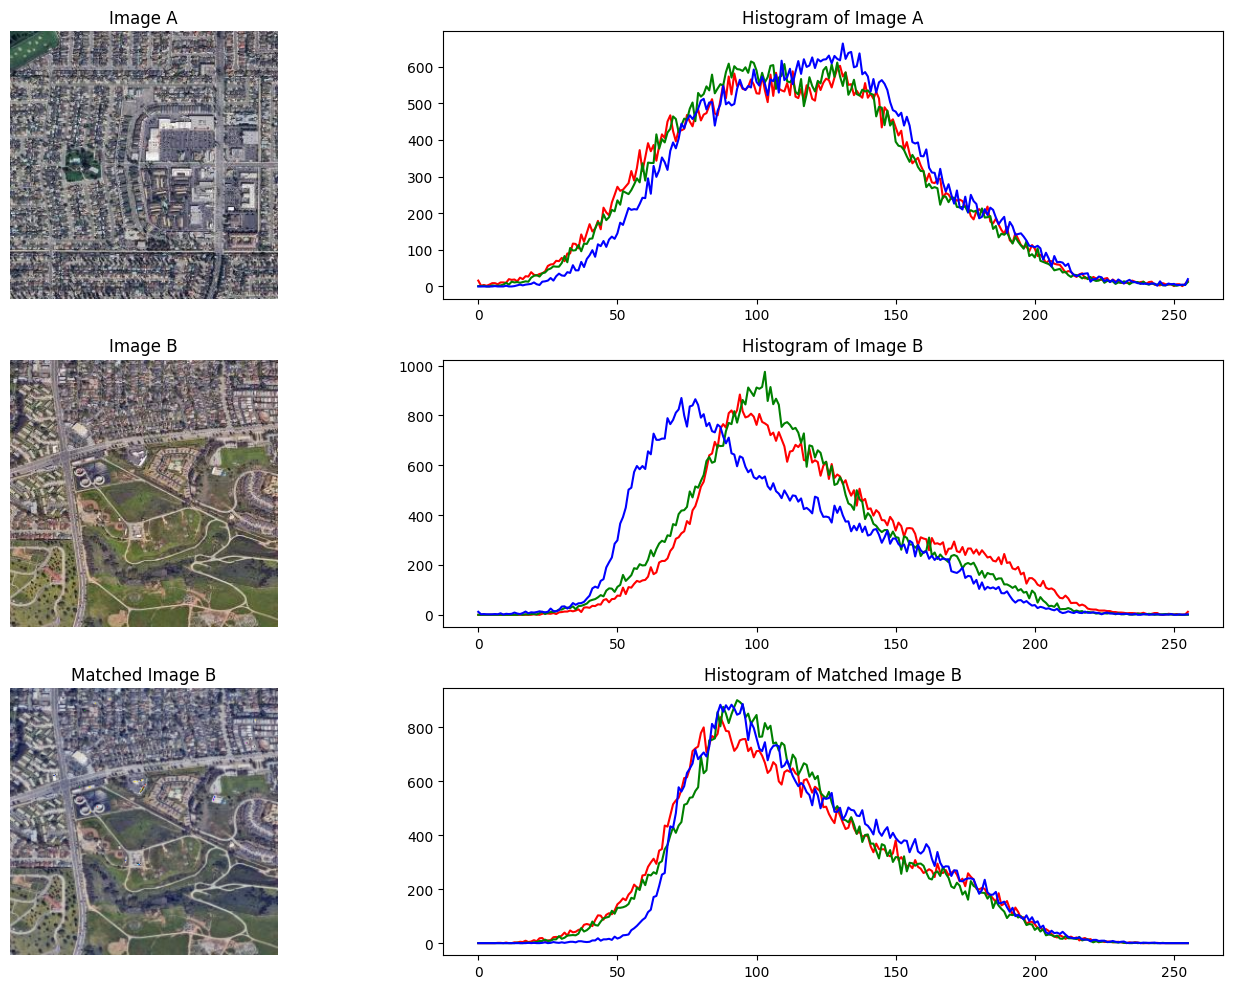

In [52]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# 定义文件路径
imageA_path = '/data_nas/liyong/GoogleEarth/images/US/LosAngeles/T202402/15/5640_5116.tif'
imageB_path = '/data_nas/liyong/GoogleEarth/images/US/LosAngeles/T202402/15/5615_5117.tif'

# 均值方差直方图矫正函数
def mean_variance_histogram_correction(source, template):
    matched = np.zeros_like(source)
    for i in range(source.shape[0]):  # 对每个波段进行处理
        # 计算源图像和模板图像的均值和方差
        source_mean = np.mean(source[i])
        source_std = np.std(source[i])
        
        template_mean = np.mean(template[i])
        template_std = np.std(template[i])
        
        # 使用均值和方差进行匹配
        matched[i] = (source[i] - source_mean) * (template_std / source_std) + template_mean
        matched[i] = np.clip(matched[i], 0, 255).astype(np.uint8)  # 确保像素值在[0, 255]范围内

    return matched

# 使用自定义函数进行匹配
with rasterio.open(imageA_path) as srcA:
    imageA = srcA.read()

with rasterio.open(imageB_path) as srcB:
    imageB = srcB.read()

matched_image_manual = mean_variance_histogram_correction(imageB, imageA)

# 对匹配后的图像进行高斯平滑
matched_image_manual = gaussian_filter(matched_image_manual, sigma=0.5)

# 创建 RGB 图像
def create_rgb_image(image, bands=(0, 1, 2)):
    # 创建一个三维数组，形状为 (高度, 宽度, 3)
    rgb_image = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
    rgb_image[..., 0] = image[bands[0]]  # 红色波段
    rgb_image[..., 1] = image[bands[1]]  # 绿色波段
    rgb_image[..., 2] = image[bands[2]]  # 蓝色波段
    return rgb_image

# 创建 RGB 图像
imageA_rgb = create_rgb_image(imageA)
imageB_rgb = create_rgb_image(imageB)
matched_image_rgb = create_rgb_image(matched_image_manual)

# 绘制RGB通道的直方图
def plot_histogram(image, title, axes):
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        axes.plot(np.histogram(image[i], bins=256, range=(0, 255))[0], color=color)
    axes.set_title(title)

# 可视化三张图像的 RGB 图像及其直方图
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# 显示图像 A 和其直方图
axes[0, 0].imshow(imageA_rgb)  # 显示 RGB 图像 A
axes[0, 0].set_title('Image A')
axes[0, 0].axis('off')  # 关闭坐标轴
plot_histogram(imageA_rgb.transpose(2, 0, 1), 'Histogram of Image A', axes[0, 1])

# 显示图像 B 和其直方图
axes[1, 0].imshow(imageB_rgb)  # 显示 RGB 图像 B
axes[1, 0].set_title('Image B')
axes[1, 0].axis('off')  # 关闭坐标轴
plot_histogram(imageB_rgb.transpose(2, 0, 1), 'Histogram of Image B', axes[1, 1])

# 显示匹配后的图像 B 和其直方图
axes[2, 0].imshow(matched_image_rgb)  # 显示匹配后的 RGB 图像
axes[2, 0].set_title('Matched Image B')
axes[2, 0].axis('off')  # 关闭坐标轴
plot_histogram(matched_image_rgb.transpose(2, 0, 1), 'Histogram of Matched Image B', axes[2, 1])

plt.tight_layout()
plt.show()


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

# 定义文件路径
imageA_path = '/data_nas/liyong/GoogleEarth/images/US/LosAngeles/T202402/15/5640_5116.tif'
imageB_path = '/data_nas/liyong/GoogleEarth/images/US/LosAngeles/T202402/15/5615_5117.tif'

# 计算累积分布函数 (CDF)
def calculate_cdf(histogram):
    cdf = histogram.cumsum()
    cdf = cdf / cdf[-1]  # 归一化
    return cdf

# 直方图匹配函数
def match_histograms_manual(source, template):
    matched = np.zeros_like(source)
    for i in range(source.shape[0]):  # 对每个波段进行直方图匹配
        src_hist, bins = np.histogram(source[i].ravel(), bins=256, range=(0, 255), density=True)
        tmpl_hist, _ = np.histogram(template[i].ravel(), bins=256, range=(0, 255), density=True)

        src_cdf = calculate_cdf(src_hist)
        tmpl_cdf = calculate_cdf(tmpl_hist)

        # 使用线性插值找到匹配的像素值
        # interp_values = np.interp(source[i].ravel(), bins[:-1], src_cdf)
        interp_values = np.interp(source[i].ravel(), bins[:-1], src_cdf)
        matched_values = np.interp(interp_values, tmpl_cdf, bins[:-1])

        matched[i] = matched_values.reshape(source[i].shape)
    return matched

# 使用自定义函数进行匹配
with rasterio.open(imageA_path) as srcA:
    imageA = srcA.read()

with rasterio.open(imageB_path) as srcB:
    imageB = srcB.read()

matched_image_manual = match_histograms_manual(imageB, imageA)

from scipy.ndimage import gaussian_filter

# 对匹配后的图像进行高斯平滑
matched_image_manual = gaussian_filter(matched_image_manual, sigma=0.5)
# 创建 RGB 图像
def create_rgb_image(image, bands=(0, 1, 2)):
    # 创建一个三维数组，形状为 (高度, 宽度, 3)
    rgb_image = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
    rgb_image[..., 0] = image[bands[0]]  # 红色波段
    rgb_image[..., 1] = image[bands[1]]  # 绿色波段
    rgb_image[..., 2] = image[bands[2]]  # 蓝色波段
    return rgb_image

# 创建 RGB 图像
imageA_rgb = create_rgb_image(imageA)
imageB_rgb = create_rgb_image(imageB)
matched_image_rgb = create_rgb_image(matched_image_manual)

# 绘制RGB通道的直方图
def plot_histogram(image, title, axes):
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        axes.plot(np.histogram(image[i], bins=256, range=(0, 255))[0], color=color)
    axes.set_title(title)

# 可视化三张图像的 RGB 图像及其直方图
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# 显示图像 A 和其直方图
axes[0, 0].imshow(imageA_rgb)  # 显示 RGB 图像 A
axes[0, 0].set_title('Image A')
axes[0, 0].axis('off')  # 关闭坐标轴
plot_histogram(imageA_rgb.transpose(2, 0, 1), 'Histogram of Image A', axes[0, 1])

# 显示图像 B 和其直方图
axes[1, 0].imshow(imageB_rgb)  # 显示 RGB 图像 B
axes[1, 0].set_title('Image B')
axes[1, 0].axis('off')  # 关闭坐标轴
plot_histogram(imageB_rgb.transpose(2, 0, 1), 'Histogram of Image B', axes[1, 1])

# 显示匹配后的图像 B 和其直方图
axes[2, 0].imshow(matched_image_rgb)  # 显示匹配后的 RGB 图像
axes[2, 0].set_title('Matched Image B')
axes[2, 0].axis('off')  # 关闭坐标轴
plot_histogram(matched_image_rgb.transpose(2, 0, 1), 'Histogram of Matched Image B', axes[2, 1])

plt.tight_layout()
plt.show()


## 区域平均

In [16]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# 定义文件夹路径
shp_path = '/data_nas/liyong/GoogleEarth/metadata/US/LosAngeles/15_T202402.shp'  # .shp 文件路径
output_folder = '/data_nas/liyong/GoogleEarth/histogram/images/US/LosAngeles/T202402/15/'  # 输出文件夹

# 创建输出文件夹
os.makedirs(output_folder, exist_ok=True)

# 读取 shapefile
gdf = gpd.read_file(shp_path)

# 统计 'NAME' 列的值
name_counts = gdf['NAME'].value_counts()

# 确定 A 为出现次数最多的区域
A_name = name_counts.idxmax()

# 获取与该区域相关的影像文件
image_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.tif')]

# 初始化直方图累加器
hist_sum_band1 = np.zeros(256)
hist_sum_band2 = np.zeros(256)
hist_sum_band3 = np.zeros(256)
image_count = 0

for image_file in image_files:
    with rasterio.open(image_file) as src:
        image = src.read()  # 读取影像数据 (波段, 高度, 宽度)

        # 对每个波段计算直方图
        hist_band1, _ = np.histogram(image[0].ravel(), bins=256, range=(0, 255))  # 第一个波段
        hist_band2, _ = np.histogram(image[1].ravel(), bins=256, range=(0, 255))  # 第二个波段
        hist_band3, _ = np.histogram(image[2].ravel(), bins=256, range=(0, 255))  # 第三个波段

        # 累加每个波段的直方图
        hist_sum_band1 += hist_band1
        hist_sum_band2 += hist_band2
        hist_sum_band3 += hist_band3

        image_count += 1

# 计算每个波段的平均直方图
average_hist_band1 = hist_sum_band1 / image_count
average_hist_band2 = hist_sum_band2 / image_count
average_hist_band3 = hist_sum_band3 / image_count

# 创建一个 RGB 图像用于绘图
def plot_histogram(average_hists, title, axes):
    colors = ('r', 'g', 'b')
    for i, (hist, color) in enumerate(zip(average_hists, colors)):
        axes.plot(hist, color=color)
    axes.set_title(title)
    axes.set_xlabel('Pixel Intensity')
    axes.set_ylabel('Frequency')
    axes.grid(True)
# 对匹配后的图像进行高斯平滑

# 可视化平均直方图
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
plot_histogram([average_hist_band1, average_hist_band2, average_hist_band3], f'Average Histogram of Region {A_name}', axes)
plt.tight_layout()
plt.show()


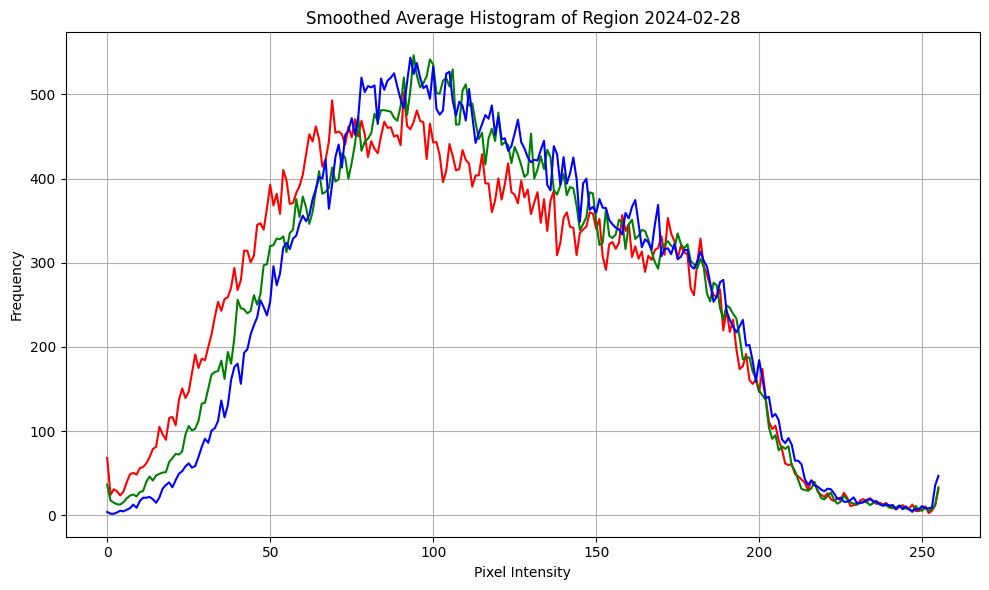

In [28]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# 定义文件夹路径
shp_path = '/data_nas/liyong/GoogleEarth/metadata/US/LosAngeles/15_T202402.shp'  # .shp 文件路径
output_folder = '/data_nas/liyong/GoogleEarth/histogram/images/US/LosAngeles/T202402/15/'  # 输出文件夹

# 创建输出文件夹
os.makedirs(output_folder, exist_ok=True)

# 读取 shapefile
gdf = gpd.read_file(shp_path)

# 统计 'NAME' 列的值
name_counts = gdf['NAME'].value_counts()

# 确定 A 为出现次数最多的区域
A_name = name_counts.idxmax()

# 获取与该区域相关的影像文件
image_files = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.tif')]

# 初始化直方图累加器
hist_sum_band1 = np.zeros(256)
hist_sum_band2 = np.zeros(256)
hist_sum_band3 = np.zeros(256)
image_count = 0

for image_file in image_files:
    with rasterio.open(image_file) as src:
        image = src.read()  # 读取影像数据 (波段, 高度, 宽度)

        # 对每个波段计算直方图
        hist_band1, _ = np.histogram(image[0].ravel(), bins=256, range=(0, 255))  # 第一个波段
        hist_band2, _ = np.histogram(image[1].ravel(), bins=256, range=(0, 255))  # 第二个波段
        hist_band3, _ = np.histogram(image[2].ravel(), bins=256, range=(0, 255))  # 第三个波段

        # 累加每个波段的直方图
        hist_sum_band1 += hist_band1
        hist_sum_band2 += hist_band2
        hist_sum_band3 += hist_band3

        image_count += 1

# 计算每个波段的平均直方图
average_hist_band1 = hist_sum_band1 / image_count
average_hist_band2 = hist_sum_band2 / image_count
average_hist_band3 = hist_sum_band3 / image_count

# 对每个波段的平均直方图进行高斯平滑
sigma = 0.5  # 设置高斯平滑的标准差
smoothed_hist_band1 = gaussian_filter1d(average_hist_band1, sigma)
smoothed_hist_band2 = gaussian_filter1d(average_hist_band2, sigma)
smoothed_hist_band3 = gaussian_filter1d(average_hist_band3, sigma)

# 创建一个 RGB 图像用于绘图
def plot_histogram(smoothed_hists, title, axes):
    colors = ('r', 'g', 'b')
    for i, (hist, color) in enumerate(zip(smoothed_hists, colors)):
        axes.plot(hist, color=color)
    axes.set_title(title)
    axes.set_xlabel('Pixel Intensity')
    axes.set_ylabel('Frequency')
    axes.grid(True)

# 可视化平均直方图
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
plot_histogram([smoothed_hist_band1, smoothed_hist_band2, smoothed_hist_band3], f'Smoothed Average Histogram of Region {A_name}', axes)
plt.tight_layout()
plt.show()


In [30]:
average_hist_band1

array([ 74.35265073,  16.29781705,  33.23154886,  28.54339917,
        22.26897089,  27.59459459,  39.49220374,  49.68269231,
        50.94256757,  46.66398129,  57.18035343,  56.68970894,
        61.50571726,  68.56912682,  80.25467775,  77.56055094,
       110.08549896,  95.83653846,  84.78196466, 119.0966736 ,
       118.5704262 , 100.90072765, 139.61720374, 153.9485447 ,
       136.53560291, 145.18529106, 168.25883576, 197.01585239,
       170.13097713, 188.82848233, 181.33861746, 200.50675676,
       213.81808732, 235.23414761, 257.995842  , 238.57952183,
       259.24246362, 257.78742204, 267.73258836, 301.57822245,
       261.79261954, 276.25519751, 319.46829522, 315.61642412,
       297.83783784, 304.07718295, 350.14007277, 348.0220894 ,
       334.79002079, 363.61538462, 400.77260915, 360.73518711,
       389.70400208, 345.18581081, 420.46517672, 399.24532225,
       365.90488565, 369.64137214, 383.78742204, 390.38851351,
       403.38097713, 427.58108108, 457.69802495, 439.11

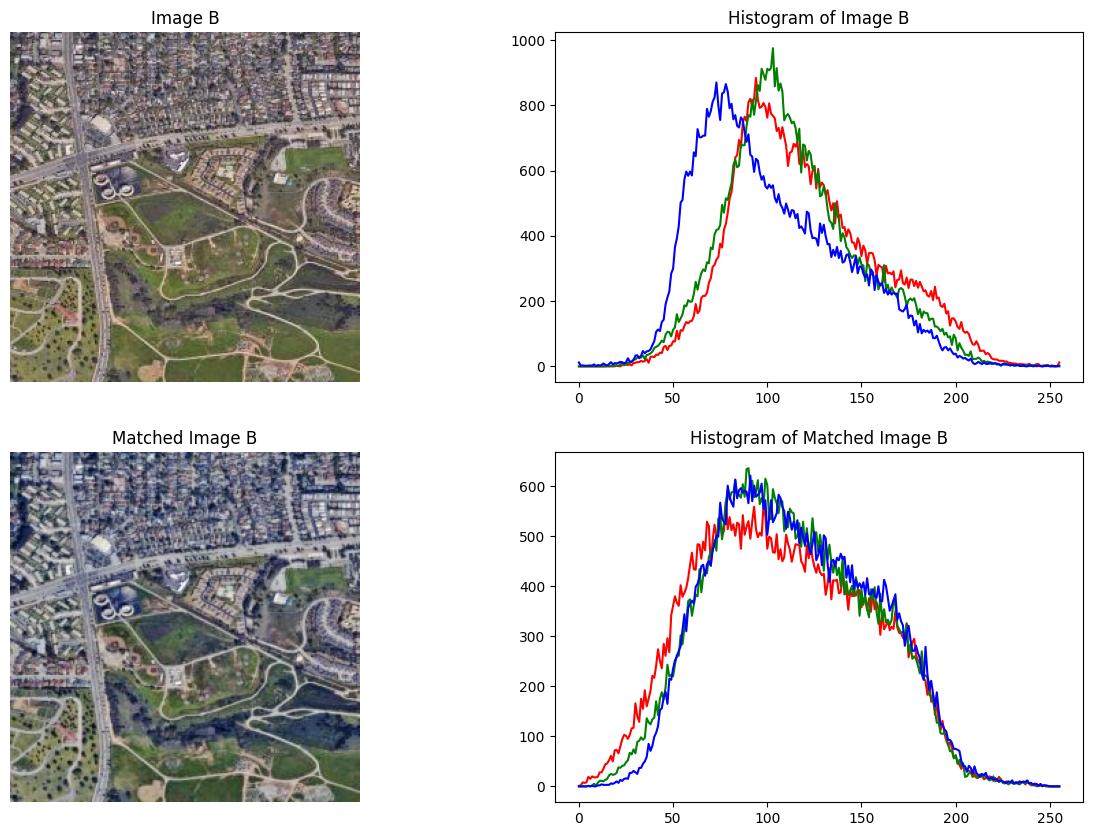

In [35]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 定义文件夹路径
imageB_path = '/data_nas/liyong/GoogleEarth/images/US/LosAngeles/T202402/15/5615_5117.tif'  # 图像 B 路径

# 读取图像 B
with rasterio.open(imageB_path) as srcB:
    imageB = srcB.read()  # 读取影像数据 (波段, 高度, 宽度)

# 计算累积分布函数 (CDF)
def calculate_cdf(histogram):
    cdf = histogram.cumsum()
    cdf = cdf / cdf[-1]  # 归一化
    return cdf

# 直方图匹配函数
def match_histograms_to_average(source, average_hist):
    matched = np.zeros_like(source)
    for i in range(source.shape[0]):  # 对每个波段进行直方图匹配
        # 计算源图像的直方图
        src_hist, bins = np.histogram(source[i].ravel(), bins=256, range=(0, 255))
        
        # 计算源图像的CDF
        src_cdf = calculate_cdf(src_hist)

        # 使用线性插值进行匹配
        # 将源图像的CDF与平均直方图的CDF进行匹配
        matched_values = np.interp(src_cdf, calculate_cdf(average_hist[i]), bins[:-1])
        
        # 将匹配后的值应用于源图像
        matched[i] = np.interp(source[i].ravel(), bins[:-1], matched_values).reshape(source[i].shape)
    
    return matched


# 使用自定义函数进行匹配
matched_image_B = match_histograms_to_average(imageB, [average_hist_band1, average_hist_band2, average_hist_band3])

from scipy.ndimage import gaussian_filter

# 对匹配后的图像进行高斯平滑
matched_image_B = gaussian_filter(matched_image_B, sigma=0.5)

# 创建 RGB 图像
def create_rgb_image(image, bands=(0, 1, 2)):
    rgb_image = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
    rgb_image[..., 0] = image[bands[0]]  # 红色波段
    rgb_image[..., 1] = image[bands[1]]  # 绿色波段
    rgb_image[..., 2] = image[bands[2]]  # 蓝色波段
    return rgb_image

# 创建 RGB 图像
matched_image_B_rgb = create_rgb_image(matched_image_B)
imageB_rgb = create_rgb_image(imageB)

# 绘制RGB通道的直方图
def plot_histogram(image, title, axes):
    colors = ('r', 'g', 'b')
    for i, color in enumerate(colors):
        axes.plot(np.histogram(image[i], bins=256, range=(0, 255))[0], color=color)
    axes.set_title(title)

# 可视化三张图像的 RGB 图像及其直方图
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # 显示图像 A 和其直方图
# axes[0, 0].imshow(imageA_rgb)  # 显示 RGB 图像 A
# axes[0, 0].set_title('Image A')
# axes[0, 0].axis('off')  # 关闭坐标轴
# plot_histogram(imageA_rgb.transpose(2, 0, 1), 'Histogram of Image A', axes[0, 1])

# 显示图像 B 和其直方图
axes[0, 0].imshow(imageB_rgb)  # 显示 RGB 图像 B
axes[0, 0].set_title('Image B')
axes[0, 0].axis('off')  # 关闭坐标轴
plot_histogram(imageB_rgb.transpose(2, 0, 1), 'Histogram of Image B', axes[0, 1])

# 显示匹配后的图像 B 和其直方图
axes[1, 0].imshow(matched_image_B_rgb)  # 显示匹配后的 RGB 图像
axes[1, 0].set_title('Matched Image B')
axes[1, 0].axis('off')  # 关闭坐标轴
plot_histogram(matched_image_B_rgb.transpose(2, 0, 1), 'Histogram of Matched Image B', axes[1, 1])


In [48]:
import os
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm  # 导入进度条库
import shutil

# 定义文件夹路径
shp_path = '/data_nas/liyong/GoogleEarth/metadata/US/LosAngeles/15_T202402.shp'  # .shp 文件路径
output_folder = '/data_nas/liyong/GoogleEarth/histogram/images/US/LosAngeles/T202402/15/'  # 输出文件夹

# 创建输出文件夹
os.makedirs(output_folder, exist_ok=True)

# 读取 shapefile
gdf = gpd.read_file(shp_path)

# 统计 'NAME' 列的值
name_counts = gdf['NAME'].value_counts()

# 确定 A 为出现次数最多的区域
A_name = name_counts.idxmax()
B_names = name_counts.index[name_counts.index != A_name]  # 剩余区域 B

# 获取与区域 A 相关的影像文件路径
A_image_files = gdf[gdf['NAME'] == A_name]['path'].tolist()  # 从 shapefile 中获取 A 区域的文件路径

# 复制文件到输出文件夹，并添加进度条
for image_file in tqdm(A_image_files, desc="Copy A images"):
    # 获取文件名
    filename = os.path.basename(image_file)
    # 复制文件
    shutil.copy(image_file, os.path.join(output_folder, filename))

# # 初始化直方图累加器
hist_sum_band1 = np.zeros(256)
hist_sum_band2 = np.zeros(256)
hist_sum_band3 = np.zeros(256)
image_count = 0

for image_file in A_image_files:
    with rasterio.open(image_file) as src:
        image = src.read()  # 读取影像数据 (波段, 高度, 宽度)

        # 对每个波段计算直方图
        hist_band1, _ = np.histogram(image[0].ravel(), bins=256, range=(0, 255))  # 第一个波段
        hist_band2, _ = np.histogram(image[1].ravel(), bins=256, range=(0, 255))  # 第二个波段
        hist_band3, _ = np.histogram(image[2].ravel(), bins=256, range=(0, 255))  # 第三个波段

        # 累加每个波段的直方图
        hist_sum_band1 += hist_band1
        hist_sum_band2 += hist_band2
        hist_sum_band3 += hist_band3

        image_count += 1

# 计算每个波段的平均直方图
average_hist_band1 = hist_sum_band1 / image_count
average_hist_band2 = hist_sum_band2 / image_count
average_hist_band3 = hist_sum_band3 / image_count

# 对每个波段的平均直方图进行高斯平滑
sigma = 0.5  # 设置高斯平滑的标准差
def smooth_histograms(average_hist, sigma):
    return [gaussian_filter1d(hist, sigma) for hist in average_hist]

smoothed_hists = smooth_histograms([average_hist_band1, average_hist_band2, average_hist_band3], sigma)

# 直方图匹配函数
def calculate_cdf(histogram):
    cdf = histogram.cumsum()
    cdf = cdf / cdf[-1]  # 归一化
    return cdf

def match_histograms_to_average(source, average_hist):
    matched = np.zeros_like(source)
    for i in range(source.shape[0]):  # 对每个波段进行直方图匹配
        # 计算源图像的直方图
        src_hist, bins = np.histogram(source[i].ravel(), bins=256, range=(0, 255))
        
        # 计算源图像的CDF
        src_cdf = calculate_cdf(src_hist)

        # 使用线性插值进行匹配
        matched_values = np.interp(src_cdf, calculate_cdf(average_hist[i]), bins[:-1])
        
        # 将匹配后的值应用于源图像
        matched[i] = np.interp(source[i].ravel(), bins[:-1], matched_values).reshape(source[i].shape)
    
    return matched

# 获取所有 B 区域的影像文件路径
B_image_files = gdf[gdf['NAME'].isin(B_names)]['path'].tolist()  # 从 shapefile 中获取所有 B 区域的文件路径

# 遍历区域 B 的影像文件，进行直方图匹配
for image_file in tqdm(B_image_files, desc='Processing B images', unit='file'):
    with rasterio.open(image_file) as srcB:
        b_filename = os.path.basename(image_file)  # 获取 B 图像的文件名
        imageB = srcB.read()  # 读取影像数据 (波段, 高度, 宽度)
    
        # 使用自定义函数进行匹配
        matched_image_B = match_histograms_to_average(imageB, smoothed_hists)

        matched_image_B = gaussian_filter1d(matched_image_B, sigma)
        
        # 创建 RGB 图像
        def create_rgb_image(image, bands=(0, 1, 2)):
            rgb_image = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)
            rgb_image[..., 0] = image[bands[0]]  # 红色波段
            rgb_image[..., 1] = image[bands[1]]  # 绿色波段
            rgb_image[..., 2] = image[bands[2]]  # 蓝色波段
            return rgb_image
        
        # 创建 RGB 图像
        matched_image_B_rgb = create_rgb_image(matched_image_B)
        
        # 将 RGB 图像的形状调整为 (波段数, 高度, 宽度)
        matched_image_B_rgb = matched_image_B_rgb.transpose(2, 0, 1)  # 从 (高度, 宽度, 波段数) 转换为 (波段数, 高度, 宽度)

        matched_output_path = os.path.join(output_folder, b_filename)

        # 写入 GeoTIFF 文件
        with rasterio.open(matched_output_path, 'w', driver='GTiff', height=matched_image_B_rgb.shape[1],
                        width=matched_image_B_rgb.shape[2], count=matched_image_B_rgb.shape[0],
                        dtype=matched_image_B_rgb.dtype, crs=srcB.crs, transform=srcB.transform) as dstB:
            dstB.write(matched_image_B_rgb)  # 将 RGB 图像写入文件

Processing B images: 100%|██████████| 3848/3848 [08:17<00:00,  7.74file/s]


mean 

In [58]:
import os
import rasterio
import numpy as np
import geopandas as gpd
from tqdm import tqdm  # Import progress bar library
import shutil

# Define folder paths
shp_path = '/data_nas/liyong/GoogleEarth/metadata/US/LosAngeles/15_T202402.shp'  # Path to the .shp file
output_folder = '/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15/'  # Output folder

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Read shapefile
gdf = gpd.read_file(shp_path)

# Count occurrences in the 'NAME' column
name_counts = gdf['NAME'].value_counts()

# Determine the area with the highest occurrence (A)
A_name = name_counts.idxmax()
B_names = name_counts.index[name_counts.index != A_name]  # Remaining areas (B)

# Get paths of images related to area A
A_image_files = gdf[gdf['NAME'] == A_name]['path'].tolist()  # File paths of area A images

# # Copy A images to output folder with progress bar
# for image_file in tqdm(A_image_files, desc="Copying A images"):
#     filename = os.path.basename(image_file)
#     shutil.copy(image_file, os.path.join(output_folder, filename))

# Initialize histogram accumulators
image_count = 0

# 定义单张图像的路径
imageA_path = '/data_nas/liyong/GoogleEarth/images/US/LosAngeles/T202402/15/5640_5116.tif'
# Initialize mean and variance accumulators for area A
mean_band1, mean_band2, mean_band3 = 0, 0, 0
var_band1, var_band2, var_band3 = 0, 0, 0




# 读取单张图像并计算均值和方差
with rasterio.open(imageA_path) as src:
    image = src.read()  # 读取影像数据 (波段, 高度, 宽度)

    # 计算每个波段的均值
    mean_band1 = image[0].mean()
    mean_band2 = image[1].mean()
    mean_band3 = image[2].mean()

    # 计算每个波段的方差
    var_band1 = image[0].var(ddof=1)  # ddof=1 用于无偏估计
    var_band2 = image[1].var(ddof=1)
    var_band3 = image[2].var(ddof=1)

    

# Function to perform mean-variance histogram correction
def mean_variance_histogram_correction(source, target_mean, target_var):
    corrected = np.zeros_like(source)
    for i in range(source.shape[0]):  # For each band
        source_mean = source[i].mean()
        source_var = source[i].var(ddof=1)

        # Adjust the source band
        corrected[i] = (source[i] - source_mean) * np.sqrt(target_var[i] / source_var) + target_mean[i]
        
        # Clip values to valid range
        corrected[i] = np.clip(corrected[i], 0, 255).astype(np.uint8)
    
    return corrected

# Get paths of all images in area B
B_image_files = gdf[gdf['NAME'].isin(B_names)]['path'].tolist()  # File paths of all B area images

# Process images in area B
for image_file in tqdm(B_image_files, desc='Processing B images', unit='file'):
    with rasterio.open(image_file) as srcB:
        b_filename = os.path.basename(image_file)  # Get B image filename
        imageB = srcB.read()  # Read image data (bands, height, width)

        # Perform mean-variance histogram correction
        corrected_image_B = mean_variance_histogram_correction(imageB, 
                                                                np.array([mean_band1, mean_band2, mean_band3]), 
                                                                np.array([var_band1, var_band2, var_band3]))

        # Define output path for corrected image
        matched_output_path = os.path.join(output_folder, b_filename)

        # Write corrected RGB image to GeoTIFF file
        with rasterio.open(matched_output_path, 'w', driver='GTiff', height=corrected_image_B.shape[1],
                        width=corrected_image_B.shape[2], count=corrected_image_B.shape[0],
                        dtype=corrected_image_B.dtype, crs=srcB.crs, transform=srcB.transform) as dstB:
            dstB.write(corrected_image_B)  # Write corrected image to file


Processing B images: 100%|██████████| 3848/3848 [04:10<00:00, 15.38file/s]


In [47]:
matched_image_B_rgb.shape

(256, 256, 3)

## metadata

In [55]:
import os
import geopandas as gpd

# 定义文件路径
shp_path = '/data_nas/liyong/GoogleEarth/metadata/US/LosAngeles/15_T202402.shp'  # .shp 文件路径
output_folder = '/data_nas/liyong/GoogleEarth/mean_variance_histogram/metadata/US/LosAngeles/T202402/15/'  # 输出文件夹
out_name = '15_T202402.shp'

# 创建输出文件夹
os.makedirs(output_folder, exist_ok=True)

# 读取 shapefile
gdf = gpd.read_file(shp_path)

# 修改 path 列的值
gdf['path'] = gdf['path'].str.replace('GoogleEarth/images', 'GoogleEarth/mean_variance_histogram/images')

# 保存为新的 shapefile
output_shp_path = os.path.join(output_folder, out_name)
gdf.to_file(output_shp_path)

print(f"Modified shapefile saved to: {output_shp_path}")


Modified shapefile saved to: /data_nas/liyong/GoogleEarth/mean_variance_histogram/metadata/US/LosAngeles/T202402/15/15_T202402.shp


In [56]:
import os
import geopandas as gpd
import rasterio

# 定义 shapefile 路径
shp_path = '/data_nas/liyong/GoogleEarth/mean_variance_histogram/metadata/US/LosAngeles/T202402/15/15_T202402.shp'  # .shp 文件路径

# 读取 shapefile
gdf = gpd.read_file(shp_path)

# 检查 'path' 列中的每个路径是否存在，并打印波段数量
missing_paths = []
band_counts = {}  # 存储每个路径的波段数量

for path in gdf['path']:
    if not os.path.exists(path):
        missing_paths.append(path)
    else:
        with rasterio.open(path) as src:
            band_counts[path] = src.count  # 获取波段数量

# 输出结果
if missing_paths:
    print("以下路径不存在：")
    for missing in missing_paths:
        print(missing)
else:
    print("所有路径都存在。")

# 打印每个图像的波段数量
print("\n图像的波段数量：")
for path, count in band_counts.items():
    print(f"{path}: {count} 波段")


所有路径都存在。

图像的波段数量：
/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15/5675_5102.tif: 3 波段
/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15/5611_5068.tif: 3 波段
/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15/5614_5106.tif: 3 波段
/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15/5606_5065.tif: 3 波段
/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15/5648_5115.tif: 3 波段
/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15/5590_5084.tif: 3 波段
/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15/5660_5076.tif: 3 波段
/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15/5665_5097.tif: 3 波段
/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15/5628_5074.tif: 3 波段
/data_nas/liyong/GoogleEarth/mean_va

In [59]:
import os
import geopandas as gpd
import rasterio
from rasterio.merge import merge
import numpy as np

# 定义 shapefile 路径
shp_path = '/data_nas/liyong/GoogleEarth/mean_variance_histogram/metadata/US/LosAngeles/T202402/15/15_T202402.shp'  # .shp 文件路径
output_path = '/data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15.tif'  # 输出合并后的图像路径

# 读取 shapefile
gdf = gpd.read_file(shp_path)

# 获取图像路径列表
image_paths = gdf['path'].tolist()

# 存储打开的图像和它们的元数据
src_files_to_mosaic = []

for image_path in image_paths:
    if os.path.exists(image_path):
        src = rasterio.open(image_path)
        src_files_to_mosaic.append(src)
    else:
        print(f"文件不存在: {image_path}")

# 合并图像
if src_files_to_mosaic:
    mosaic, out_trans = merge(src_files_to_mosaic)

    # 获取合并后的图像的元数据
    out_meta = src.meta.copy()

    # 更新元数据
    out_meta.update({
        'driver': 'GTiff',
        'height': mosaic.shape[1],
        'width': mosaic.shape[2],
        'transform': out_trans,
        'count': 3  # 因为我们知道所有图像都有三个波段
    })

    # 保存合并后的图像
    with rasterio.open(output_path, 'w', **out_meta) as dest:
        dest.write(mosaic)

    print(f"合并后的图像已保存到: {output_path}")
else:
    print("没有有效的图像可供合并。")

# 关闭打开的图像
for src in src_files_to_mosaic:
    src.close()


合并后的图像已保存到: /data_nas/liyong/GoogleEarth/mean_variance_histogram/images/US/LosAngeles/T202402/15.tif
